In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone --branch fra https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 1399, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 1399 (delta 186), reused 241 (delta 115), pack-reused 1024
Receiving objects: 100% (1399/1399), 32.39 MiB | 38.74 MiB/s, done.
Resolving deltas: 100% (682/682), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature
from polimi.utils._custom import *

from catboost import CatBoostClassifier

# Memory Utils

In [4]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.4039


In [5]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [6]:
articles = pl.read_parquet('/kaggle/input/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.6626


# Articles Preprocessing

In [7]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')) 
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 57.99 MB
Memory usage after optimization is: 57.84 MB
Decreased by 0.3%

RAM memory GB usage = 0.6673


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116


In [8]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['ORG', 'PROD', 'LOC', 'EVENT', 'MISC', 'PER']

In [9]:
unique_categories = articles.select('category')['category'].unique().to_list()
unique_categories = [c for c in unique_categories if c is not None]
len(unique_categories)

25

In [10]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 0.6849


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32]
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]"


In [12]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [13]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [14]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 16.3 s, sys: 4.04 ms, total: 16.3 s
Wall time: 16.3 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]","[0.285677, 0.280758, … 0.144301]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]","[0.316672, 0.220132, … 0.11284]"


In [15]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]",0.285677,0.280758,0.144219,0.145045,0.144301
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]",0.316672,0.220132,0.1309,0.219456,0.11284


# History preprocessing

In [16]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [17]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:09,  1.71it/s]                        



RAM memory GB usage = 0.812
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 10.8 s, sys: 848 ms, total: 11.6 s
Wall time: 9.65 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,ORGPct,PRODPct,LOCPct,EVENTPct,MISCPct,PERPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,3,16,"[0.016041, 0.062928, … 0.178427]",0.888112,0.237762,0.804196,0.202797,0.223776,0.874126
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.852273,0.318182,0.776515,0.087121,0.117424,0.787879


In [18]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [19]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [20]:
ner_mapping.shape

(43774, 2)

In [21]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [22]:
%cd RecSys_Course_AT_PoliMi

/kaggle/working/RecSysChallenge2024/src/RecSys_Course_AT_PoliMi


In [23]:
%cd /kaggle/working/RecSys_Course_AT_PoliMi

from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

[Errno 2] No such file or directory: '/kaggle/working/RecSys_Course_AT_PoliMi'
/kaggle/working/RecSysChallenge2024/src/RecSys_Course_AT_PoliMi
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 277.88 column/sec. Elapsed time 2.63 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 34.42 sec. Users per second: 439


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214433,0.214676,0.469902,0.319612,0.054883,0.766609,0.953152,...,0.997953,0.76504,0.997953,0.002086,5.362616,0.952586,0.016842,0.419597,3.357942,0.009295


In [24]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.55 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 15.98 sec. Users per second: 946


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342642,0.345154,0.04867,0.261772,0.263218,0.670427,0.39227,0.085232,0.858655,1.275611,...,0.997953,0.856898,0.997953,0.001871,5.929584,0.95823,0.015105,0.463959,3.324192,0.009294


In [25]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 1min 47s, sys: 2min 6s, total: 3min 53s
Wall time: 1min 3s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
547493010,9775331,0.162051,0.648202,0.788581,0.15479,0.61916,0.762809
518143310,9746360,0.856088,0.110434,0.632399,0.80426,0.110536,0.685654
36210880,7213923,0.0,0.0,0.0,0.0,0.0,0.0
218589428,9774376,0.005849,0.017548,0.015409,0.071486,0.16683,0.128685
109329227,9775800,0.065173,0.137588,0.450525,0.046366,0.097884,0.370222


In [26]:
print(behaviors_ner_scores.shape)
print(ner_inview_scores.shape)

(2585747, 8)
(13017188, 6)


# Creating Training Dataframe

In [27]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, 
                                with_replacement=True, seed=123) \
    .pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_mean_delays_features, articles=articles, history=history_train) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .pipe(add_history_trendiness_scores_feature, history=history_train, articles=articles) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left')\
    

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()


RAM memory GB usage = 2.164
Memory usage of dataframe is 110.29 MB
Memory usage after optimization is: 83.61 MB
Decreased by 24.2%

RAM memory GB usage = 2.151
CPU times: user 2min 18s, sys: 4.86 s, total: 2min 23s
Wall time: 44.3 s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32
215261649,9775699,1013010,2023-05-22 08:40:57,0,1,28.0,null,false,2,null,false,1035364,11.991596,290.564026,5.983402,146.074692,345,220.767639,354.907227,1,8,false,2023-05-22 07:59:05,512,0.6038,"""Positive""",3,7,26,294,0,0,true,false,true,false,false,true,0.732467,1.0,1.0,0.99081,1.0,1.0
325349348,9775713,261053,2023-05-23 08:35:34,1,1,9.0,null,false,2,null,false,1648598,3.738029,92.240929,0.0,2.457143,81,200.885712,211.793198,2,8,false,2023-05-23 07:03:58,118,0.9836,"""Negative""",1,10,27,292,0,1,true,false,true,false,false,true,0.267894,0.234408,0.334213,0.391146,0.342253,0.570238
307485145,9772858,908205,2023-05-19 16:12:17,0,2,19.0,null,false,2,null,false,343441,2.564983,63.754803,0.659864,20.414967,40,198.823135,122.762947,5,16,false,2023-05-19 15:38:04,118,0.9955,"""Negative""",1,4,12,258,0,0,true,false,true,false,false,true,-0.007799,-0.006499,0.027996,0.077889,0.064907,0.122305
47215697,9777043,1052806,2023-05-23 09:51:55,0,1,35.0,100.0,false,2,null,false,1600240,15.11193,365.576935,0.041667,4.083333,211,245.458328,293.239532,2,9,false,2023-05-23 08:33:48,414,0.5112,"""Positive""",2,7,28,290,0,1,false,true,true,false,false,true,0.031243,0.059646,0.247832,0.043423,0.082898,0.462357
368523321,9778915,1092307,2023-05-24 14:07:31,1,1,9.0,null,false,2,null,false,1817085,7.899652,192.236389,0.123288,4.712329,68,253.938354,172.481461,3,14,false,2023-05-24 10:09:44,512,0.9679,"""Negative""",2,5,36,298,0,3,true,false,true,false,true,true,0.514553,0.659815,0.715021,0.196611,0.265149,0.2387


In [28]:
train_ds.shape

(699537, 45)

## Recsys Features

### mappings

In [29]:
user_mapping_train = history_train.select('user_id').sort('user_id').unique().with_row_index().rename({'index': 'user_index'})
user_mapping_val = history_val.select('user_id').sort('user_id').unique().with_row_index().rename({'index': 'user_index'})
item_mapping = articles.select('article_id').sort('article_id').unique().with_row_index().rename({'index': 'item_index'})

### create urm

In [30]:
urm_train = history_train.select('user_id','article_id_fixed').explode('article_id_fixed').unique().join(user_mapping_train,on='user_id').join(item_mapping,left_on='article_id_fixed',right_on='article_id').unique(['user_index','item_index']).rename({'article_id_fixed':'article_id'})


URM_train = sps.csr_matrix((np.ones(urm_train.shape[0]),
                          (urm_train['user_index'].to_numpy(), urm_train['item_index'].to_numpy())),
                         shape=(user_mapping_train.shape[0], item_mapping.shape[0]))

urm_validation = history_val.select('user_id','article_id_fixed').explode('article_id_fixed').unique().join(user_mapping_val,on='user_id').join(item_mapping,left_on='article_id_fixed',right_on='article_id').unique(['user_index','item_index']).rename({'article_id_fixed':'article_id'})

URM_val = sps.csr_matrix((np.ones(urm_validation.shape[0]),
                          (urm_validation['user_index'].to_numpy(), urm_validation['item_index'].to_numpy())),
                         shape=(user_mapping_val.shape[0], item_mapping.shape[0]))

### train models

In [31]:
pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=20)

rp3 = RP3betaRecommender(URM_train)
rp3.fit()

knn = ItemKNNCFRecommender(URM_train)
knn.fit()

pure_svd_val = PureSVDRecommender(URM_val)
pure_svd_val.fit(num_factors=20)

rp3_val = RP3betaRecommender(URM_val)
rp3_val.fit()

knn_val = ItemKNNCFRecommender(URM_val)
knn_val.fit()

PureSVDRecommender: URM Detected 11952 (57.6%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.58 sec
RP3betaRecommender: URM Detected 11952 (57.6%) items with no interactions.
RP3betaRecommender: Similarity column 20738 (100.0%), 3096.43 column/sec. Elapsed time 6.70 sec
ItemKNNCFRecommender: URM Detected 11952 (57.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 20738 (100.0%), 1400.97 column/sec. Elapsed time 14.80 sec
PureSVDRecommender: URM Detected 12029 (58.0%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.57 sec
RP3betaRecommender: URM Detected 12029 (58.0%) items with no interactions.
RP3betaRecommender: Similarity column 20738 (100.0%), 3318.17 column/sec. Elapsed time 6.25 sec
ItemKNNCFRecommender: URM Detected 12029 (58.0%) items

### add recsys features

In [32]:
dict_train = {
    'PureSVDRecommender': pure_svd,
    'RP3betaRecommender': rp3,
    'ItemKNNCFRecommender': knn
}


In [33]:
def get_recommender_scores(user_items_df, recommenders):
    user_index = user_items_df['user_index'].to_list()[0]
    items = user_items_df['item_index'].to_numpy()
    
    scores = {} 
    for name, model in recommenders.items():
        scores[name] = model._compute_item_score([user_index], items)[0, items]
    
    return user_items_df.with_columns(
        [
            pl.Series(model).alias(name) for name,model in scores.items()
        ]
    )


train_ds = train_ds\
.join(user_mapping_train,on='user_id')\
.join(item_mapping,left_on='article',right_on='article_id')\
.sort(['user_index','item_index']).group_by('user_index').map_groups(
    lambda df: df.pipe(get_recommender_scores, recommenders=dict_train)
).drop('user_index','item_index')

train_ds


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,PureSVDRecommender,RP3betaRecommender,ItemKNNCFRecommender
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32
385198819,9762352,10068,2023-05-24 18:58:45,0,2,17.0,100.0,false,2,null,false,1969198,10.621649,257.855042,4.210526,107.105263,206,209.473679,295.832001,3,18,false,2023-05-12 15:26:56,498,0.6981,"""Neutral""",2,4,15,102,12,291,false,true,true,true,false,true,1.0,0.562871,1.0,1.0,0.32973,1.0,0.071849,0.00881,0.910534
556008624,9772548,10068,2023-05-25 04:48:16,0,2,185.0,100.0,false,2,null,false,1969199,1.940446,48.898483,4.210526,107.105263,183,209.473679,412.395081,4,4,true,2023-05-24 14:23:57,142,0.99,"""Negative""",8,7,39,968,0,14,true,false,true,true,true,true,0.577324,0.388406,0.271759,0.884342,0.423922,0.377553,0.0,0.0,0.0
385198819,9777321,10068,2023-05-24 18:58:45,0,2,17.0,100.0,false,2,null,false,1969198,2.014889,50.732357,4.210526,107.105263,388,209.473679,403.959595,3,18,true,2023-05-23 09:52:05,142,0.7393,"""Neutral""",1,7,21,1,1,33,true,false,false,false,false,false,0.197401,1.0,0.496436,0.336976,1.0,0.986103,0.0,0.0,0.0
385198819,9779737,10068,2023-05-24 18:58:45,1,2,17.0,100.0,false,2,null,false,1969198,7.701305,187.264771,4.210526,107.105263,186,209.473679,156.975922,3,18,false,2023-05-24 18:29:29,140,0.9939,"""Negative""",0,6,19,127,0,0,true,false,true,false,false,true,-0.002684,-0.002267,0.0,0.017295,0.008554,0.050612,0.0,0.0,0.0
556008624,9779748,10068,2023-05-25 04:48:16,1,2,185.0,100.0,false,2,null,false,1969199,8.623199,209.78772,4.210526,107.105263,320,209.473679,311.922791,4,4,false,2023-05-24 18:38:13,414,0.9719,"""Negative""",4,4,13,262,0,10,true,true,true,false,false,true,0.138336,0.093068,0.103438,0.185552,0.088947,0.180969,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
567760515,9779423,2590637,2023-05-24 19:38:33,0,2,10.0,null,false,2,null,false,1587767,6.954053,169.231003,0.140625,4.796875,169,268.78125,127.682556,3,19,false,2023-05-24 18:22:24,140,0.9978,"""Negative""",1,8,29,145,0,1,true,false,true,false,false,true,0.202733,0.270311,0.461555,0.22976,0.314159,0.621531,0.0,0.0,0.0
567760513,9779423,2590637,2023-05-24 19:38:17,1,2,10.0,null,false,2,null,false,1587767,6.954053,169.231003,0.140625,4.796875,169,268.78125,127.682556,3,19,false,2023-05-24 18:22:24,140,0.9978,"""Negative""",1,8,29,145,0,1,true,false,true,false,false,true,0.202733,0.270311,0.605556,0.235619,0.314159,0.724625,0.0,0.0,0.0
567760515,9779517,2590637,2023-05-24 19:38:33,0,2,10.0,null,false,2,null,false,1587767,17.494804,422.714722,0.140625,4.796875,257,268.78125,286.085541,3,19,false,2023-05-24 16:48:02,414,0.5283,"""Neutral""",1,5,11,244,0,2,true,false,true,false,false,true,0.966646,0.703015,1.0,1.0,0.745818,1.0,0.0,0.0,0.0


## Session Features

In [34]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [35]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 2.488
CPU times: user 1.14 s, sys: 104 ms, total: 1.24 s
Wall time: 997 ms


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
1156435,2023-05-18 06:59:42,0,[9769366],0.0
960461,2023-05-18 05:36:51,0,[9769712],0.0


In [36]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 2.587


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,PureSVDRecommender,RP3betaRecommender,ItemKNNCFRecommender,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,f64,i64,bool,bool
385198819,9762352,10068,2023-05-24 18:58:45,0,2,17.0,100.0,false,2,null,false,10.621649,257.855042,4.210526,107.105263,206,209.473679,295.832001,3,18,false,498,0.6981,"""Neutral""",2,4,15,102,12,291,false,true,true,true,false,true,1.0,0.562871,1.0,1.0,0.32973,1.0,0.071849,0.00881,0.910534,0,0.0,-9,true,false
556008624,9772548,10068,2023-05-25 04:48:16,0,2,185.0,100.0,false,2,null,false,1.940446,48.898483,4.210526,107.105263,183,209.473679,412.395081,4,4,true,142,0.99,"""Negative""",8,7,39,968,0,14,true,false,true,true,true,true,0.577324,0.388406,0.271759,0.884342,0.423922,0.377553,0.0,0.0,0.0,0,0.0,200,false,false


In [37]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.532103,0.018289


In [38]:
train_ds.shape

(699537, 51)

In [39]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [40]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}).drop(['impression_time']) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 99.87 MB
Memory usage after optimization is: 85.77 MB
Decreased by 14.1%

RAM memory GB usage = 2.586
CPU times: user 424 ms, sys: 7.29 ms, total: 431 ms
Wall time: 368 ms


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,PureSVDRecommender,RP3betaRecommender,ItemKNNCFRecommender,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
385198819,9762352,10068,0,2,17.0,100.0,false,2,null,false,10.621649,257.855042,4.210526,107.105263,206,209.473679,295.832001,3,18,false,498,0.6981,"""Neutral""",2,4,15,102,12,291,false,true,true,true,false,true,1.0,0.562871,1.0,1.0,0.32973,1.0,0.071849,0.00881,0.910534,0,0.0,-9,true,false,0.007246
556008624,9772548,10068,0,2,185.0,100.0,false,2,null,false,1.940446,48.898483,4.210526,107.105263,183,209.473679,412.395081,4,4,true,142,0.99,"""Negative""",8,7,39,968,0,14,true,false,true,true,true,true,0.577324,0.388406,0.271759,0.884342,0.423922,0.377553,0.0,0.0,0.0,0,0.0,200,false,false,0.239437


# Adding history features

In [41]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the number of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


def batch_cosine_similarity(df, col1, col2, target_col):
    X = np.array(df[col1].to_list())
    Y = np.array(df[col2].to_list())
    norm = np.linalg.norm(X, 2, axis=1) * np.linalg.norm(Y, 2, axis=1)
    cosine = np.where(norm > 0, np.sum(X * Y, axis=1) / norm, 0)
    return df.with_columns(pl.Series(cosine).alias(target_col))


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            [pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns] + \
            [pl.col(x).mul(pl.col(x)) for x in topic_model_columns] + \
            [pl.col(f'{x}_history').mul(pl.col(f'{x}_history')) for x in topic_model_columns]
        ).with_columns(
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

70it [05:40,  4.87s/it]



RAM memory GB usage = 2.888


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,total_ner_svd_scores,…,yesterday_category_daily_pct,MeanCommonEntities,MaxCommonEntities,mean_JS,min_JS,max_JS,std_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,ORGPct,PRODPct,LOCPct,EVENTPct,MISCPct,PERPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,…,f32,f64,u32,f64,f64,f64,f64,f32,f32,f32,f32,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u32,f64
477109184,9772660,14241,0,1,11.0,null,false,2,null,false,3.647643,90.061989,14.005587,337.625702,114,224.497208,197.569534,5,15,false,118,0.986,"""Negative""",1,4,11,299,0,2,true,false,true,false,false,true,1.0,…,0.352381,2.558659,3,0.091594,0.0,1.0,0.212479,0.823471,0.555678,0.998428,0.102541,179,19.0,1574.0,7754.0,100.0,100.0,0.251397,0.106145,0.642458,0.145251,0.050279,0.564246,0.022346,118,3,13,0.921788,0.217877,0.793296,0.128492,0.162011,0.843575,0.370463,true,8,0.960894
339846845,9761586,19915,1,1,31.0,100.0,true,2,60,false,9.866658,239.443207,6.061403,149.891815,94,249.204681,176.763824,3,6,false,140,0.9932,"""Negative""",3,6,18,533,0,10,true,true,true,false,false,true,0.095142,…,0.166667,3.017544,4,0.128443,0.0,1.0,0.280766,0.852005,0.553725,0.997853,0.079758,342,18.0,1435.0,15557.0,100.0,100.0,0.210526,0.149123,0.640351,0.076023,0.114035,0.602339,0.011696,118,2,6,0.912281,0.365497,0.853801,0.248538,0.157895,0.885965,0.314032,false,8,0.979532


In [42]:
# .pipe(batch_cosine_similarity, col1='topics_idf', col2='topics_flatten_tf_idf', target_col='topics_cosine') \

In [43]:
train_ds.columns

['impression_id',
 'article',
 'user_id',
 'target',
 'device_type',
 'read_time',
 'scroll_percentage',
 'is_sso_user',
 'gender',
 'age',
 'is_subscriber',
 'mean_topics_mean_delay_days',
 'mean_topics_mean_delay_hours',
 'user_mean_delay_days',
 'user_mean_delay_hours',
 'trendiness_score',
 'mean_user_trendiness_score',
 'mean_topics_trendiness_score',
 'weekday',
 'hour',
 'premium',
 'category',
 'sentiment_score',
 'sentiment_label',
 'num_images',
 'title_len',
 'subtitle_len',
 'body_len',
 'article_delay_days',
 'article_delay_hours',
 'Entity_ORG_Present',
 'Entity_PROD_Present',
 'Entity_LOC_Present',
 'Entity_EVENT_Present',
 'Entity_MISC_Present',
 'Entity_PER_Present',
 'total_ner_svd_scores',
 'mean_ner_svd_scores',
 'max_ner_svd_scores',
 'total_ner_item_knn_scores',
 'mean_ner_item_knn_scores',
 'max_ner_item_knn_scores',
 'PureSVDRecommender',
 'RP3betaRecommender',
 'ItemKNNCFRecommender',
 'last_session_duration',
 'mean_prev_sessions_duration',
 'last_session_time

In [44]:
train_ds.shape

(699537, 87)

# Training

In [45]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [46]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 3.113


In [47]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.318943
0:	learn: 0.6269852	total: 944ms	remaining: 7m 51s
25:	learn: 0.5451819	total: 21.4s	remaining: 6m 29s
50:	learn: 0.5360949	total: 40.8s	remaining: 5m 58s
75:	learn: 0.5292118	total: 1m	remaining: 5m 36s
100:	learn: 0.5245891	total: 1m 20s	remaining: 5m 17s
125:	learn: 0.5210175	total: 1m 39s	remaining: 4m 56s
150:	learn: 0.5179977	total: 1m 59s	remaining: 4m 36s
175:	learn: 0.5155240	total: 2m 19s	remaining: 4m 17s
200:	learn: 0.5131576	total: 2m 39s	remaining: 3m 56s
225:	learn: 0.5109542	total: 2m 59s	remaining: 3m 37s
250:	learn: 0.5090277	total: 3m 18s	remaining: 3m 16s
275:	learn: 0.5073115	total: 3m 38s	remaining: 2m 56s
300:	learn: 0.5057406	total: 3m 57s	remaining: 2m 37s
325:	learn: 0.5038341	total: 4m 18s	remaining: 2m 17s
350:	learn: 0.5023938	total: 4m 37s	remaining: 1m 57s
375:	learn: 0.5009247	total: 4m 57s	remaining: 1m 38s
400:	learn: 0.4997671	total: 5m 16s	remaining: 1m 18s
425:	learn: 0.4984101	total: 5m 36s	remaining: 58.5s
450:	learn:

In [48]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 5.1 s, sys: 40.1 ms, total: 5.14 s
Wall time: 5.03 s


Text(0.5, 1.0, 'Catboost Feature Importances')

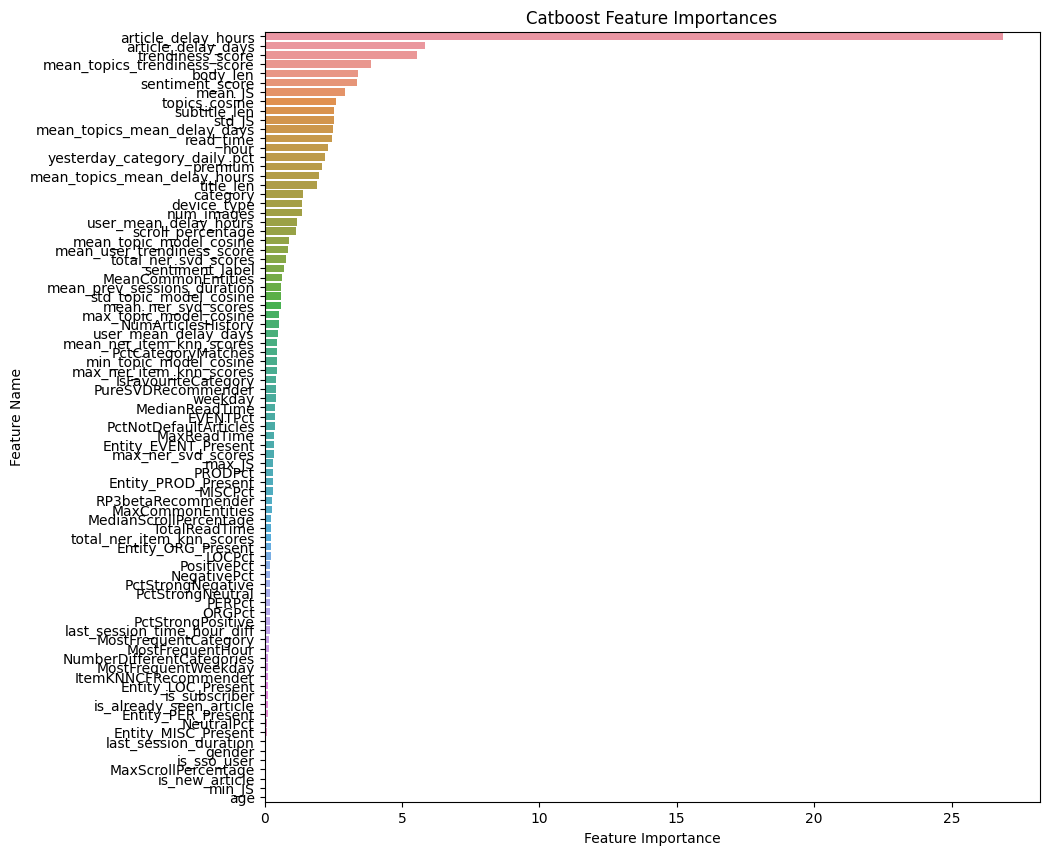

In [49]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [50]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 4.368


In [51]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_ORG_Present',
 'Entity_PROD_Present',
 'Entity_LOC_Present',
 'Entity_EVENT_Present',
 'Entity_MISC_Present',
 'Entity_PER_Present']

# Model Evaluation

In [52]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [53]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 289.49 column/sec. Elapsed time 2.52 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 34.87 sec. Users per second: 439


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033197,0.241643,0.241977,0.493913,0.346767,0.060464,0.784651,1.033204,...,0.997914,0.783014,0.997914,0.002568,5.473111,0.953841,0.020621,0.428217,3.43338,0.010093


In [54]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 3.39 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 17.25 sec. Users per second: 887


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365408,0.368574,0.050851,0.283647,0.285737,0.696533,0.415957,0.089278,0.876094,1.344211,...,0.997914,0.874267,0.997914,0.001528,5.729531,0.954894,0.012273,0.44828,3.53976,0.010001


In [55]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 1min 56s, sys: 2min 5s, total: 4min 1s
Wall time: 1min 5s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
454673173,9142581,0.003316,0.00597,0.002473,0.003745,0.006688,0.002382
38683935,9780677,0.019717,0.031275,0.057734,0.025241,0.039626,0.067984
156596491,9783314,0.046987,0.163477,0.100137,0.03434,0.137886,0.081445
241844135,9788849,0.076364,0.322982,0.110966,0.119406,0.424774,0.176969
30808650,9789433,0.012037,0.021241,0.031964,0.021207,0.037076,0.051172


In [56]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_ORG_Present',
 'Entity_PROD_Present',
 'Entity_LOC_Present',
 'Entity_EVENT_Present',
 'Entity_MISC_Present',
 'Entity_PER_Present']

In [57]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:08,  1.82it/s]                        



RAM memory GB usage = 4.366
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 10.2 s, sys: 832 ms, total: 11 s
Wall time: 9.13 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,ORGPct,PRODPct,LOCPct,EVENTPct,MISCPct,PERPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.913333,0.213333,0.846667,0.3,0.266667,0.893333
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,1,7,"[0.0, 0.048524, … 0.217846]",0.947368,0.254386,0.815789,0.114035,0.192982,0.807018


In [58]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [59]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_mean_delays_features, articles=articles, history=history_val) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .pipe(add_history_trendiness_scores_feature, history=history_val, articles=articles) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}).drop(['impression_time']) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0)) \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left')\
    

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()


RAM memory GB usage = 5.247
Memory usage of dataframe is 496.25 MB
Memory usage after optimization is: 325.52 MB
Decreased by 34.4%

RAM memory GB usage = 5.082
CPU times: user 4min 50s, sys: 11.6 s, total: 5min 2s
Wall time: 1min 27s


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,f32,f32,f32,f32,f32,f32
355443351,9780604,2120677,0,2,63.0,null,false,2,null,false,5.990736,146.317322,8.434783,206.482208,177,187.169968,269.747284,1,5,false,118,0.5153,"""Neutral""",3,6,14,335,0,13,true,false,true,false,false,false,2,1.615385,74,false,false,0.309735,0.090152,0.067022,0.065122,0.124105,0.098758,0.101157
455500270,9777983,905758,0,2,161.0,100.0,false,2,null,false,12.021604,291.404327,3.43128,86.483414,75,223.909958,262.506805,3,6,false,414,0.8666,"""Positive""",0,7,20,89,1,47,true,false,false,false,false,true,5,6.833333,138,false,false,0.116788,0.0,0.0,0.0,0.0,0.0,0.0
46791993,9777983,2203163,0,2,48.0,null,false,2,null,false,12.021604,291.404327,0.09434,4.924528,74,139.471695,262.506805,2,14,false,414,0.8666,"""Positive""",0,7,20,89,1,31,true,false,false,false,false,true,0,2.076923,99,false,false,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
415478512,9785835,2107297,0,1,88.0,100.0,true,0,70,false,40.976849,987.021362,0.196078,6.480392,95,202.970581,170.663879,2,16,false,118,0.9056,"""Neutral""",0,7,27,151,1,44,true,false,false,false,false,true,0,0.0,145,false,false,0.268519,0.0,0.0,0.0,0.0,0.0,0.0
64868372,9566461,157786,0,2,12.0,100.0,false,2,null,false,26.916012,649.535217,195.223236,4690.34375,118,186.261963,135.030014,4,15,true,140,0.9946,"""Negative""",3,7,30,689,146,3525,true,false,true,false,false,false,0,1.222222,-49,true,false,0.140845,0.652305,0.488486,0.38988,0.536217,0.364329,0.334027


In [60]:
val_ds.shape

(2928942, 48)

### Recsys features

In [61]:
dict_val = {
    'PureSVDRecommender': pure_svd_val,
    'RP3betaRecommender': rp3_val,
    'ItemKNNCFRecommender': knn_val
}

val_ds = val_ds\
.join(user_mapping_val,on='user_id')\
.join(item_mapping,left_on='article',right_on='article_id')\
.sort(['user_index','item_index']).group_by('user_index').map_groups(
    lambda df: df.pipe(get_recommender_scores, recommenders=dict_val)
).drop('user_index','item_index')

val_ds

impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,PureSVDRecommender,RP3betaRecommender,ItemKNNCFRecommender
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
80366312,7213923,10200,0,2,18.0,null,false,2,null,false,71.009972,1708.299805,6.277228,153.0,50,149.35643,196.553268,6,5,true,565,0.8109,"""Neutral""",5,10,42,1048,1764,42336,false,false,false,false,false,false,1,0.25,45,true,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025769,0.021887,0.476576
225664678,7594265,10200,0,2,4.0,null,false,2,null,false,89.117447,2143.625244,6.277228,153.0,51,149.35643,186.830322,4,8,true,565,0.8108,"""Neutral""",8,7,26,1559,1488,35726,false,false,false,false,false,false,0,0.333333,-66,true,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014628,0.0,0.176417
225664684,7594265,10200,0,2,17.0,null,false,2,null,false,89.117447,2143.625244,6.277228,153.0,51,149.35643,186.830322,4,8,true,565,0.8108,"""Neutral""",8,7,26,1559,1488,35726,false,false,false,false,false,false,0,0.333333,-66,true,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014628,0.0,0.176417
225664679,7594265,10200,0,2,34.0,null,false,2,null,false,89.117447,2143.625244,6.277228,153.0,51,149.35643,186.830322,4,8,true,565,0.8108,"""Neutral""",8,7,26,1559,1488,35726,false,false,false,false,false,false,0,0.333333,-66,true,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014628,0.0,0.176417
322455613,9142564,10200,0,2,40.0,null,false,2,null,false,49.040138,1180.714966,6.277228,153.0,180,149.35643,225.428879,6,21,true,414,0.955,"""Neutral""",4,5,23,868,456,10955,true,false,true,false,false,true,1,0.428571,28,true,false,0.100775,0.093579,0.054721,0.072285,0.072349,0.039947,0.059189,0.023771,0.006542,0.281577
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
185972553,9790278,2590637,0,2,6.0,null,false,2,null,false,3.470918,85.708588,0.123288,4.068493,80,256.671234,177.712921,3,16,false,118,0.699,"""Neutral""",1,5,9,216,0,0,true,true,true,false,false,true,0,0.0,139,false,false,0.306569,0.254551,0.86761,0.341464,0.282826,0.3631,0.356814,0.0,0.0,0.0
185972553,9790406,2590637,0,2,6.0,null,false,2,null,false,3.666086,90.499763,0.123288,4.068493,83,256.671234,220.61615,3,16,false,118,0.9185,"""Neutral""",1,9,18,313,0,1,true,false,true,false,false,true,0,0.0,139,false,false,0.306569,-0.223116,-1.140702,0.00062,0.194708,0.374958,0.245644,0.0,0.0,0.0
185972553,9790414,2590637,0,2,6.0,null,false,2,null,false,19.099075,461.101196,0.123288,4.068493,117,256.671234,249.939346,3,16,false,118,0.8378,"""Negative""",1,5,14,155,0,1,true,true,true,false,false,true,0,0.0,139,false,false,0.306569,0.002838,0.005804,0.003107,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            [pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns] + \
            [pl.col(x).mul(pl.col(x)) for x in topic_model_columns] + \
            [pl.col(f'{x}_history').mul(pl.col(f'{x}_history')) for x in topic_model_columns]
        ).with_columns(
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [20:53,  4.28s/it]


Memory usage of dataframe is 790.24 MB
Memory usage after optimization is: 714.83 MB
Decreased by 9.5%

RAM memory GB usage = 6.796


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_ORG_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_EVENT_Present,Entity_MISC_Present,Entity_PER_Present,total_ner_svd_scores,…,yesterday_category_daily_pct,MeanCommonEntities,MaxCommonEntities,mean_JS,min_JS,max_JS,std_JS,mean_topic_model_cosine,min_topic_model_cosine,max_topic_model_cosine,std_topic_model_cosine,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,ORGPct,PRODPct,LOCPct,EVENTPct,MISCPct,PERPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,…,f32,f32,u32,f32,f32,f32,f32,f32,f32,f32,f32,u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32
45679270,9788653,19026,0,2,97.0,100.0,false,2,null,false,4.333778,106.383797,3.647727,91.329544,338,209.704544,285.751953,3,8,false,142,0.9487,"""Negative""",3,5,19,474,0,1,true,false,true,false,false,true,0.042761,…,0.29927,2.602273,3,0.084821,0.0,0.285714,0.101334,0.755494,0.529668,0.987856,0.127713,88,44.0,895.0,7137.0,100.0,100.0,0.227273,0.284091,0.488636,0.079545,0.102273,0.409091,0.011364,118,7,22,0.886364,0.465909,0.818182,0.181818,0.238636,0.897727,0.33639,false,10,0.897727
419467675,9781796,17548,0,1,1.0,null,false,2,null,false,5.049484,123.670456,0.012739,1.535032,191,246.738861,210.281662,1,8,false,118,0.539,"""Negative""",1,6,17,295,3,81,true,false,true,false,false,true,0.020309,…,0.309735,2.541401,3,0.06719,0.0,0.5,0.110591,0.66446,0.352949,0.996632,0.179556,157,5.0,1459.0,11013.0,76.0,100.0,0.273885,0.171975,0.55414,0.10828,0.127389,0.490446,0.095541,142,4,18,0.955414,0.286624,0.757962,0.203822,0.178344,0.828025,0.251626,false,8,0.955414
382941878,9784094,15075,1,1,21.0,null,false,2,null,false,3.642022,89.905807,0.0,0.666667,159,212.238098,174.438522,6,15,false,118,0.8765,"""Negative""",1,7,14,346,0,0,true,false,true,false,false,true,0.627008,…,0.232558,2.380952,3,0.04966,0.0,0.5,0.13759,0.817487,0.57951,0.975106,0.119423,21,24.0,775.0,1616.0,71.0,100.0,0.142857,0.047619,0.809524,0.095238,0.047619,0.619048,0.095238,118,2,20,0.857143,0.142857,0.666667,0.238095,0.238095,0.857143,0.185017,true,6,0.761905
440925505,9783729,11951,0,1,19.0,null,false,2,null,false,2.708229,67.629654,0.0,1.612149,262,216.976639,383.307007,6,13,false,142,0.8483,"""Neutral""",3,5,14,469,0,4,true,false,true,true,true,true,0.141786,…,0.302326,2.901869,5,0.104339,0.0,0.8,0.200568,0.719892,0.44918,0.998278,0.158678,214,5.5,355.0,2878.0,32.0,100.0,0.205607,0.14486,0.649533,0.070093,0.056075,0.570093,0.042056,118,7,18,0.915888,0.285047,0.766355,0.205607,0.163551,0.850467,0.324163,false,9,0.962617
50932972,9783646,19026,0,2,59.0,100.0,false,2,null,false,2.824303,70.13401,3.647727,91.329544,255,209.704544,393.217255,6,9,false,142,0.9767,"""Positive""",1,5,16,151,0,2,true,false,true,true,true,true,0.024996,…,0.302326,3.022727,5,0.085417,0.0,1.0,0.192594,0.753356,0.459139,0.975042,0.119576,88,44.0,895.0,7137.0,100.0,100.0,0.227273,0.284091,0.488636,0.079545,0.102273,0.409091,0.011364,118,7,22,0.886364,0.465909,0.818182,0.181818,0.238636,0.897727,0.316527,false,10,0.897727


In [63]:
val_ds.shape

(2928942, 87)

In [64]:
val_ds.columns

['impression_id',
 'article',
 'user_id',
 'target',
 'device_type',
 'read_time',
 'scroll_percentage',
 'is_sso_user',
 'gender',
 'age',
 'is_subscriber',
 'mean_topics_mean_delay_days',
 'mean_topics_mean_delay_hours',
 'user_mean_delay_days',
 'user_mean_delay_hours',
 'trendiness_score',
 'mean_user_trendiness_score',
 'mean_topics_trendiness_score',
 'weekday',
 'hour',
 'premium',
 'category',
 'sentiment_score',
 'sentiment_label',
 'num_images',
 'title_len',
 'subtitle_len',
 'body_len',
 'article_delay_days',
 'article_delay_hours',
 'Entity_ORG_Present',
 'Entity_PROD_Present',
 'Entity_LOC_Present',
 'Entity_EVENT_Present',
 'Entity_MISC_Present',
 'Entity_PER_Present',
 'total_ner_svd_scores',
 'mean_ner_svd_scores',
 'max_ner_svd_scores',
 'total_ner_item_knn_scores',
 'mean_ner_item_knn_scores',
 'max_ner_item_knn_scores',
 'PureSVDRecommender',
 'RP3betaRecommender',
 'ItemKNNCFRecommender',
 'last_session_duration',
 'mean_prev_sessions_duration',
 'last_session_time

In [65]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_ORG_Present',
 'Entity_PROD_Present',
 'Entity_LOC_Present',
 'Entity_EVENT_Present',
 'Entity_MISC_Present',
 'Entity_PER_Present']

In [66]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doing model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
45679270,0,0.182128
419467675,0,0.028439
382941878,1,0.118135
440925505,0,0.397667
50932972,0,0.288076
…,…,…
399940465,0,0.586834
72323459,0,0.278341
400531966,0,0.222146


In [67]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
90091043,"[0, 0, … 0]","[0.005647, 0.211944, … 0.164212]"
544962482,"[0, 0, … 0]","[0.465575, 0.117361, … 0.371381]"
525388732,"[0, 0, … 0]","[0.404653, 0.564803, … 0.278081]"
475214663,"[0, 0, … 0]","[0.262807, 0.207825, … 0.419689]"
439851351,"[0, 0, … 0]","[0.052241, 0.54295, … 0.307082]"
…,…,…
85243758,"[0, 1, … 0]","[0.128929, 0.507634, … 0.42068]"
469112056,"[1, 0, … 0]","[0.153731, 0.093106, … 0.043075]"
355305548,"[0, 0, … 0]","[0.234229, 0.100546, … 0.527044]"


In [68]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)

met_eval.evaluate()



CPU times: user 4min 11s, sys: 217 ms, total: 4min 11s
Wall time: 4min 11s


<MetricEvaluator class>: 
 {
    "auc": 0.7171094390864141,
    "mrr": 0.49120596655648835,
    "ndcg@5": 0.5495462459851325,
    "ndcg@10": 0.594892193246611
}